In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from util import centroid_label, ch_label, coordinator_label, worker_label, ccolor, cmarker
from topology import get_lognorm_hist
import topology

#### Topology Setup

In [2]:
seed = 4
np.random.seed(seed)

avg = 50
c_capacity = 50

H, bins = get_lognorm_hist()
coords_df = topology.coords_PLANETLAB()
coord_dict = {"planetlab": coords_df}
device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=2, kmax=30, kseed=10)

Creating df for planetlab
Optimal k is 3
Done


In [3]:
t_label = "planetlab"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
prim_df["weight_2"] = 2
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,...,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1,weight_2
0,34.4285,-119.7220,0.000000,coordinator,219961,0,50,50,50,50,...,50,50,50,50,50,50,50,-1,1,2
1,40.7292,-73.9934,46.160629,worker,219961,12,51,52,46,55,...,64,55,53,33,36,33,12,2,1,2
2,40.7292,-73.9934,46.160629,worker,219961,1,51,53,56,58,...,54,35,30,26,18,183,108,2,1,2
3,37.4294,-122.1720,3.874003,worker,219961,2,51,49,45,53,...,62,66,41,51,17,89,0,2,1,2
4,29.7225,-95.3924,24.780554,worker,219961,3,51,52,51,53,...,67,55,43,27,40,13,77,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,34.7008,137.4100,257.132144,worker,219961,1,51,49,45,44,...,40,56,56,43,18,11,16,1,1,2
465,41.8200,-71.4200,48.864276,worker,219961,1,51,51,52,43,...,59,35,47,61,20,125,24,2,1,2
466,41.8200,-71.4200,48.864276,worker,219961,25,51,49,49,53,...,38,76,83,45,20,28,116,2,1,2
467,41.8200,-71.4200,48.864276,worker,219961,2,51,51,54,43,...,67,35,38,34,88,13,123,2,1,2


In [4]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 3381 Available: 23918


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

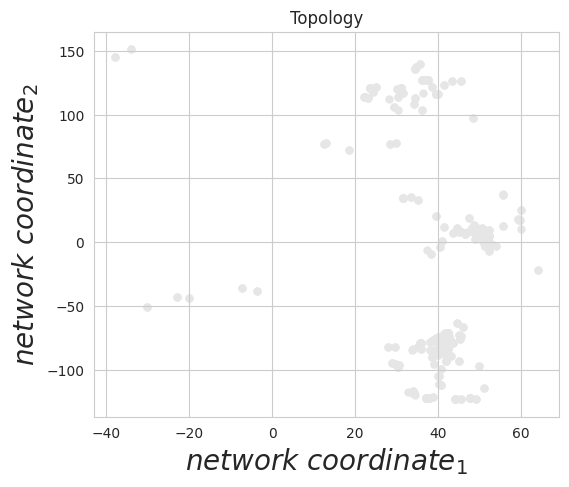

In [6]:
X_dim_def = [-50, 50]
Y_dim_def = [-60, 60]

fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))
ax1 = util.plot_topology(ax1, prim_df, show_legend=False, show_coordinator=False)

#ax1.set_xlim(X_dim_def)
#ax2.set_xlim(X_dim_def)

#ax1.set_ylim(Y_dim_def)
#ax2.set_ylim(Y_dim_def)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

plt.savefig("plots/planetlab/planetlab_ncs_plain.svg", bbox_inches="tight")

plt.show()

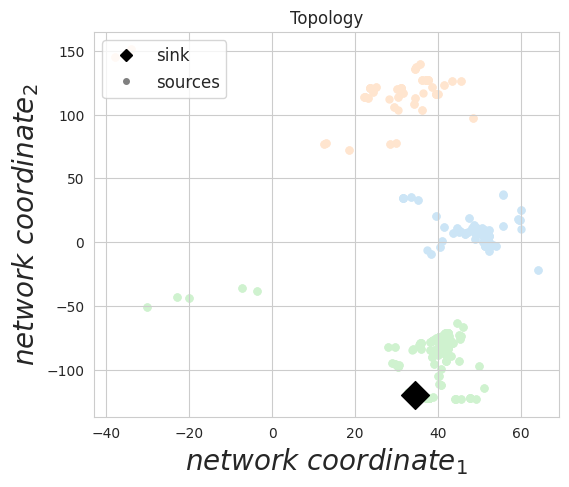

In [8]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 5))

ax1 = util.plot_topology(ax1, prim_df, colors, 'Topology (k=' + str(opt_k) + ")")

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/atlas/atlas_ncs_colored.svg", bbox_inches="tight")

plt.show()

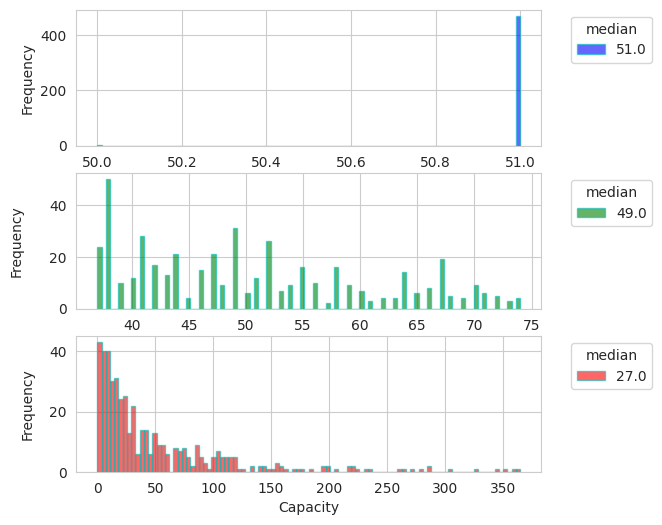

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 6))

i = 100
prim_df["capacity_" + str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c',
                                        label=prim_df["capacity_" + str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.set_xlabel("Capacity")

# Set y-axis label with padding
ax2.set_ylabel("Frequency", labelpad=18)
ax3.set_ylabel("Frequency", labelpad=10)
plt.savefig("plots/sim_1000/capacity_dist.svg", bbox_inches="tight")

plt.show()

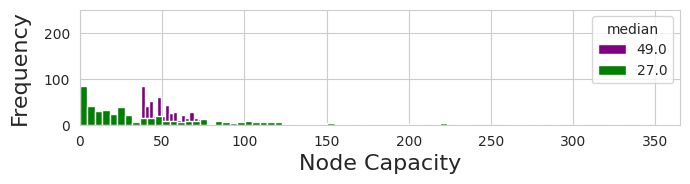

In [10]:
fig, (merged_ax) = plt.subplots(1, 1, figsize=(7, 2))

i = 50
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=15, alpha=1, color='purple',
                                        label=prim_df["capacity_" + str(i)].median())

#i = 10
#prim_df["capacity_"+str(i)].plot.hist(ax=merged_ax, bins=40, alpha=1, color='orange', label=prim_df["capacity_"+str(i)].median())

i = 1
prim_df["capacity_" + str(i)].plot.hist(ax=merged_ax, bins=80, alpha=1, color='green',
                                        label=prim_df["capacity_" + str(i)].median())

merged_ax.legend(title='median', loc='upper right')
merged_ax.set_xlabel("Node Capacity")

# Set y-axis label with padding
merged_ax.set_ylabel("Frequency", labelpad=10)

# Set the same x-axis limits for both histograms
xlim = (prim_df["capacity_1"].min(), prim_df["capacity_1"].max())
merged_ax.set_xlim(xlim)
merged_ax.set_ylim([0, 250])

merged_ax.yaxis.label.set_size(16)
merged_ax.xaxis.label.set_size(16)
#merged_ax.tick_params(axis='x', labelsize=20)

# Adjust figure layout for better display
fig.tight_layout()

plt.savefig("plots/planetlab/capacity_dist.svg", bbox_inches="tight")
plt.show()

Medians from  50  to  25


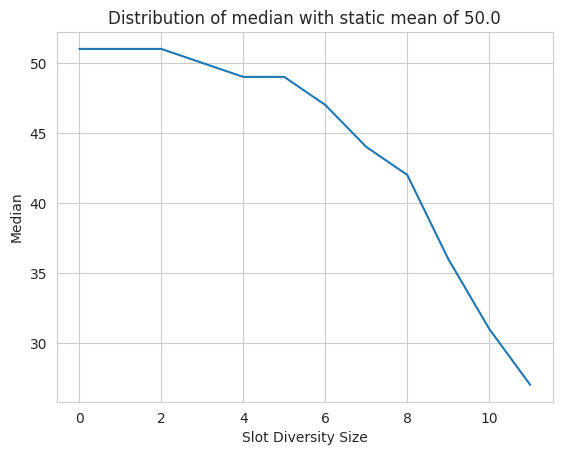

In [11]:
medians = []
mean = np.floor(prim_df["capacity_" + str(1)].mean())

for col in slot_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = "50"
last_med_label = "25"
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("Slot Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator


In [12]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
print(df_stats)
eval_matrix["dt"] = df_stats.copy()

     latency_distribution  received_packets
0                0.000000             468.0
1               46.160629               0.0
2               46.160629               0.0
3                3.874003               0.0
4               24.780554               0.0
..                    ...               ...
464            257.132144               0.0
465             48.864276               0.0
466             48.864276               0.0
467             48.864276               0.0
468             48.864276               0.0

[469 rows x 2 columns]


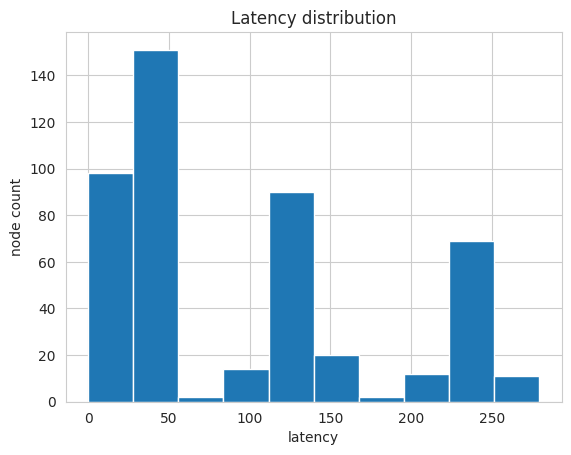

In [13]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
plt.show()

In [14]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"]
print("Distribution of workload: ", 1, "/", device_number, "=", round(len(df_packets) / device_number * 100, 5), "%")

Distribution of workload:  1 / 469 = 0.21322 %


### Experiment 1: LEACH Protocol

In [15]:
seed = 10
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(0.1*device_number)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  46
[293, 17, 220, 248, 296, 8, 106, 237, 417, 252, 422, 143, 335, 416, 83, 18, 267, 251, 168, 39, 128, 382, 185, 23, 216, 441, 72, 309, 182, 196, 146, 424, 346, 135, 234, 90, 352, 156, 339, 186, 69, 394, 123, 226, 315, 193]


In [16]:
df_stats

,latency_distribution,received_packets
0,0.000000,46.0
1,46.123949,0.0
2,46.123949,0.0
3,3.874003,0.0
4,24.780554,0.0
...,...,...
464,257.235373,0.0
465,49.282345,0.0
466,49.282345,0.0
467,49.282345,0.0


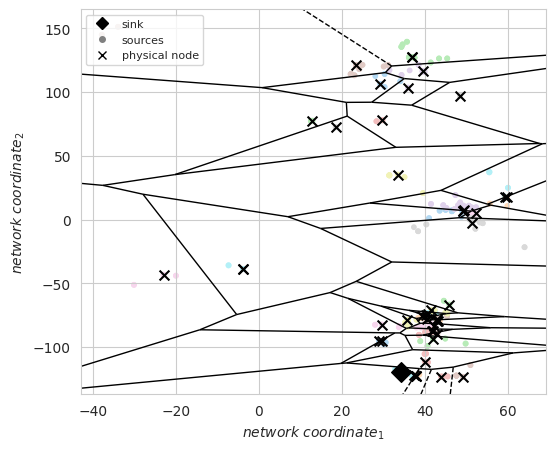

In [17]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, ch_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/planetlab/leach.svg")
plt.show()

count    469.000000
mean      99.500470
std       84.081075
min        0.000000
25%       36.858503
50%       49.282345
75%      139.700563
max      305.969943
Name: latency_distribution, dtype: float64


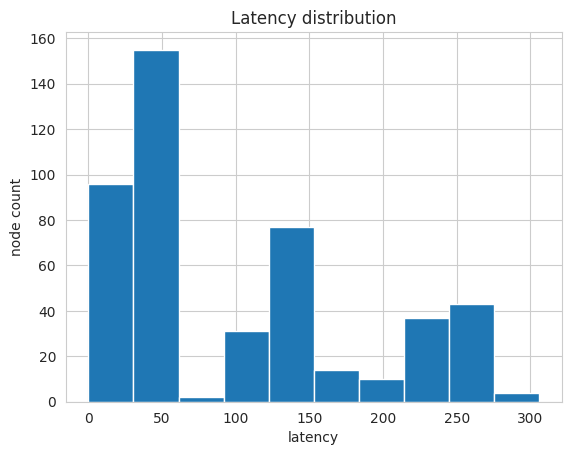

In [18]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

In [19]:
eval_matrix["leach"] = df_stats.copy()

### Experiment 2a: NEMO Aggregation with Density-based Grouping

### Identify parameters

In [24]:
# fixed params
max_levels = 50
slot_col = "capacity_100"
weight_col = "weight"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.full_like(X, fill_value=np.nan)
mean_lat_values = np.full_like(X, fill_value=np.nan)

for i in range(num_points):
    for j in range(num_points):
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j], step_size=Y[i, j], max_levels=max_levels, with_eval=True)
        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.1
Level 0 CH number:  468 Load: 3381
--------Balancing load for 3 clusters to 0
Level 1 CH number:  72 Load: 477
--------Balancing load for 1 clusters to 0
Level 2 CH number:  11 Load: 54
--------Balancing load for 1 clusters to 0
Level 3 CH number:  2 Load: 23
Evaluating for capacity_100
242.86 131.01
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.2
Level 0 CH number:  468 Load: 3381
--------Balancing load for 3 clusters to 0
Level 1 CH number:  72 Load: 477
--------Balancing load for 1 clusters to 0
Level 2 CH number:  11 Load: 54
--------Balancing load for 1 clusters to 0
Level 3 CH number:  2 Load: 23
Evaluating for capacity_100
242.86 131.01
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.30000000000000004
Level 0 CH number:  468 Load: 3381
--------Balancing load for 3 clusters to 0
Level 1 CH number:  72 Load: 477
--------Balancing lo

merge factor and step size for minimum latency (90P): (X=0.1, Y=0.4) 240.57
merge factor and step size for minimum latency (mean): (X=0.7000000000000001, Y=0.8) 101.74


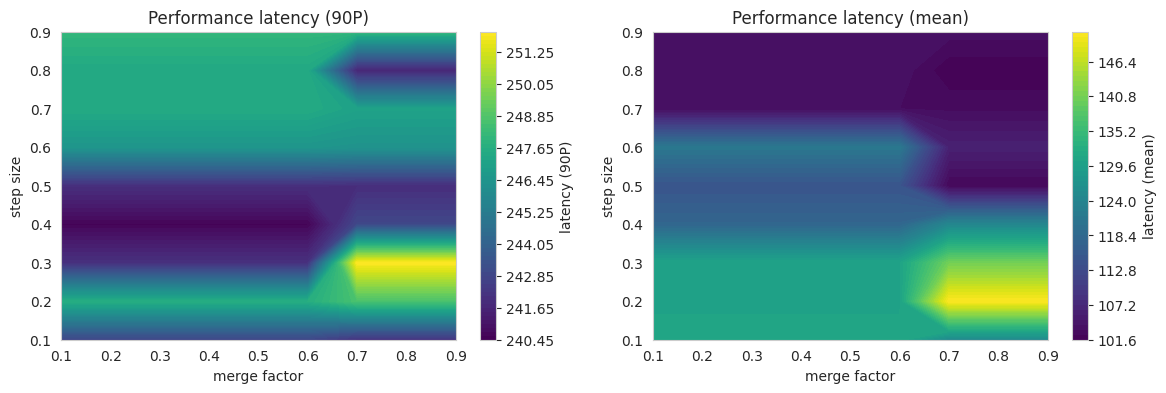

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"
        
    # Find the indices of the minimum Z value, ignoring nans
    min_index = np.unravel_index(np.nanargmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])
    
    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)
    
    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')

plt.savefig(f"plots/planetlab/nemop_params_sl_{slot_col}_w_{weight_col}.svg", bbox_inches="tight")
plt.show()

In [27]:
param_dict = {
    "weight_1": {"merge_factor": 0.1, "step_size": 0.3},
    "weight_2": {"merge_factor": 0.1, "step_size": 0.3},
    "weight": {"merge_factor": 0.1, "step_size": 0.4}
}

In [28]:
# for the eval for weights regarding latency
weight_cols = ["weight_2", "weight"]
for weight_col in weight_cols:
    eval_name = "nemo_dc" + "_" + weight_col
    eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, ["capacity_100", "capacity_1"], weight_col, merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_2, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 936
--------Balancing load for 3 clusters to 0
Level 1 CH number:  24 Load: 48
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight_2, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 936
--------Balancing load for 3 clusters to 0
Level 1 CH number:  15 Load: 30
Evaluating for capacity_1
Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.4, merge_factor=0.1
Level 0 CH number:  468 Load: 3381
--------Balancing load for 3 clusters to 0
Level 1 CH number:  72 Load: 421
--------Balancing load for 1 clusters to 0
Level 2 CH number:  11 Load: 37
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight, l=20, step_size=0.4, merge_factor=0.1
Level 0 CH number:  468 Load: 3381
--------Balancing load for 3 clusters to 0
Level 1 CH number:  54 Load: 261
--------Balancing load for 1 clusters to 0
Level 2 CH number:  4 Load: 

In [29]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight_1"
df_dict_1, opt_dict_1, limits_dict_1 = evaluate_nemo(prim_df, [slot_col], weight_col, max_levels=1, merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=False)
eval_matrix[eval_name], df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, slot_columns, weight_col, merge_factor=param_dict[weight_col]["merge_factor"], step_size=param_dict[weight_col]["step_size"], with_eval=True)

Starting nemo for: c=capacity_100, w=weight_1, l=1, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 468
--------Balancing load for 3 clusters to 0
Level 1 CH number:  13 Load: 13
Starting nemo for: c=capacity_100, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 468
--------Balancing load for 3 clusters to 0
Level 1 CH number:  13 Load: 13
Evaluating for capacity_100
Starting nemo for: c=capacity_90, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 468
--------Balancing load for 3 clusters to 0
Level 1 CH number:  13 Load: 13
Evaluating for capacity_90
Starting nemo for: c=capacity_80, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 468
--------Balancing load for 3 clusters to 0
Level 1 CH number:  13 Load: 13
Evaluating for capacity_80
Starting nemo for: c=capacity_70, w=weight_1, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 468
--------Balancing load for 

In [30]:
df = df_dict[slot_col]
df

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,34.4285,-119.7220,coordinator,-1,<NA>,<NA>,<NA>,50,37,2,<NA>,13
1,1,40.7292,-73.9934,worker,2,1,0,1,51,51,0,426,0
2,2,40.7292,-73.9934,worker,2,1,0,1,51,51,0,426,0
3,3,37.4294,-122.1720,worker,2,1,0,1,51,51,0,63,0
4,4,29.7225,-95.3924,worker,2,1,0,1,51,51,0,62,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,464,34.7008,137.4100,worker,1,1,0,1,51,51,0,340,0
465,465,41.8200,-71.4200,worker,2,1,0,1,51,51,0,425,0
466,466,41.8200,-71.4200,worker,2,1,0,1,51,51,0,425,0
467,467,41.8200,-71.4200,worker,2,1,0,1,51,51,0,425,0


In [31]:
df[df["parent"] == df["oindex"]]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load


In [32]:
df[df["parent"] == 0]

,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
46,46,30.2869,-97.7366,worker,2,1,0,1,51,37,1,0,14
62,62,30.2869,-97.7366,worker,2,1,0,1,51,17,1,0,34
63,63,30.2869,-97.7366,worker,2,1,0,1,51,10,1,0,41
73,73,38.9527,-95.2644,worker,2,1,0,1,51,10,1,0,41
74,74,38.9527,-95.2644,worker,2,1,0,1,51,10,1,0,41
236,236,64.0900,-21.5800,worker,0,1,0,1,51,13,1,0,38
265,265,64.0900,-21.5800,worker,0,1,0,1,51,10,1,0,41
339,339,33.5300,35.3000,worker,0,1,0,1,51,10,1,0,41
340,340,33.5300,35.3000,worker,0,1,0,1,51,10,1,0,41
349,349,31.5000,34.7500,worker,0,1,0,1,51,39,1,0,12


In [33]:
# check -> should be empty
df_overloaded = df.groupby(['parent'])['used_weight'].sum().copy().reset_index()
df_join = df[["oindex", "total_capacity", "free_capacity"]]
result = pd.merge(df_join, df_overloaded, left_on='oindex', right_on='parent', how='inner')
result["delta"] = result["total_capacity"] - result["used_weight"]
result[result["delta"] < 0]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [34]:
# check -> should be empty
result[result["delta"] != result["free_capacity"]]

,oindex,total_capacity,free_capacity,parent,used_weight,delta


In [35]:
result

,oindex,total_capacity,free_capacity,parent,used_weight,delta
0,0,50,37,0,13,37
1,46,51,37,46,14,37
2,62,51,17,62,34,17
3,63,51,10,63,41,10
4,73,51,10,73,41,10
5,74,51,10,74,41,10
6,236,51,13,236,38,13
7,265,51,10,265,41,10
8,339,51,10,339,41,10
9,340,51,10,340,41,10


In [36]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

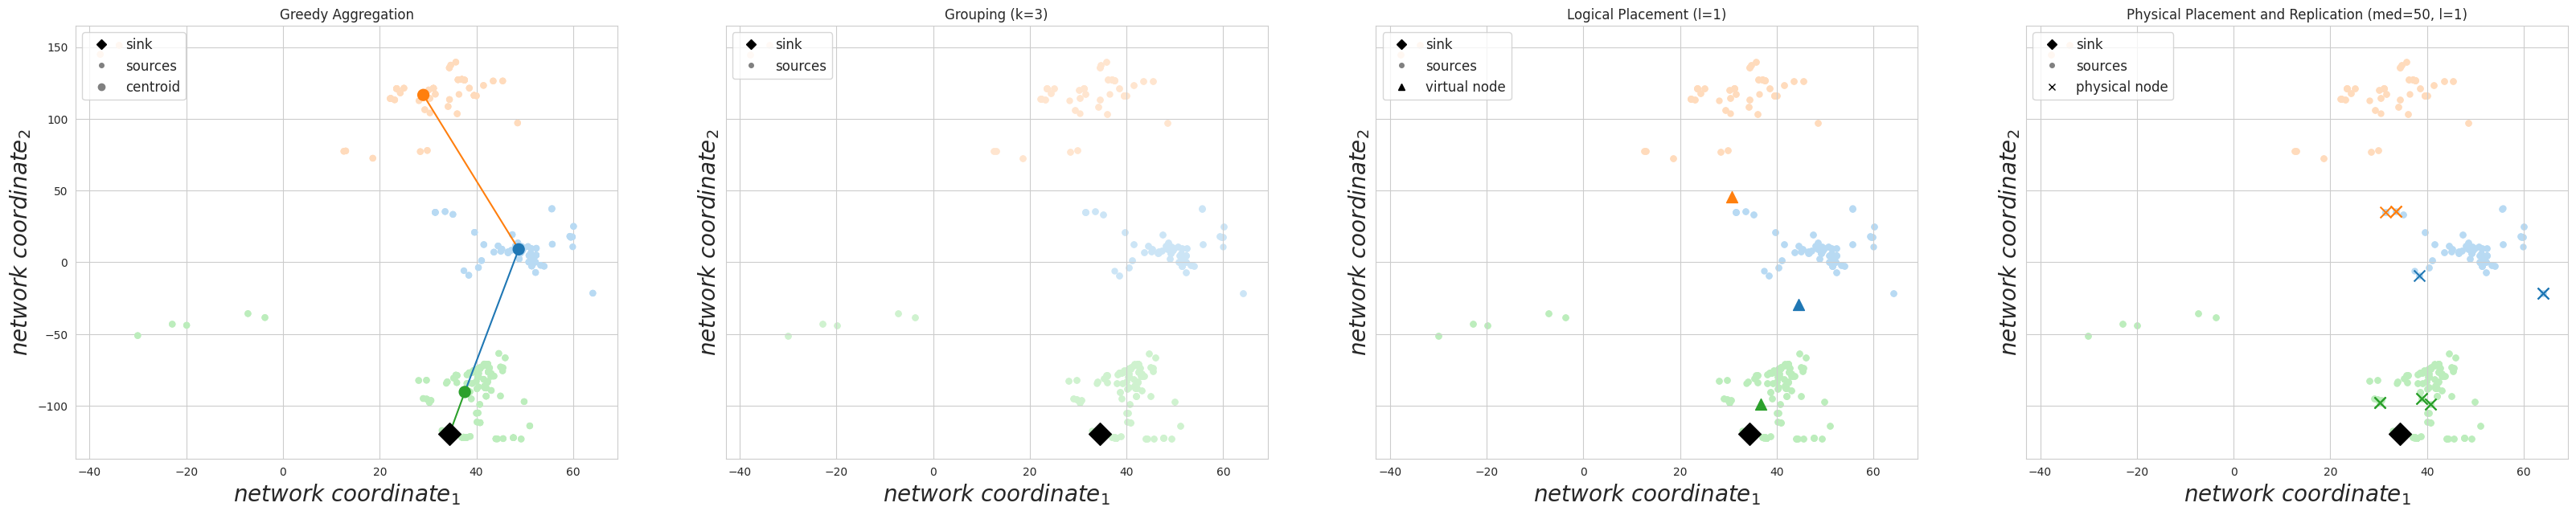

In [38]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")

lval = 0.28
leg_size = 12
symbol_size = 100
scale_fac = 0.25
axis_label_size = 20

labels = prim_df["cluster"]

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i - 1])

ax1.scatter(coords[0, 0], coords[0, 1], s=2 * symbol_size, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=symbol_size, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=scale_fac * symbol_size,
            color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1),
           fontsize=leg_size)

ax1.set_xlabel('$network$ $coordinate_1$', fontsize=axis_label_size)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=axis_label_size)
ax1.set_title('Greedy Aggregation')

#plot grouping
util.plot_topology(ax2, prim_df, colors, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

#plot logical nodes (optima) of different groups
# util.plot2(ax3, prim_df, df_dict[slot_col], colors, lval=lval, show_centroids=True)
util.plot_optimum(ax3, prim_df, opt_dict[slot_col], colors, lval=lval, plot_centroid=False, plot_lines=False,
                  leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)
# plot physical nodes
util.plot(ax4, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False,
          leg_size=leg_size, symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size)

plt.xlim(X_dim)
plt.ylim(Y_dim)
ax3.set_title("Logical Placement (l=1)")
ax4.set_title("Physical Placement and Replication (med=" + first_med_label + ", l=1)")

plt.savefig("plots/planetlab/nemo_phases.svg", bbox_inches="tight")
plt.show()

Starting nemo for: c=capacity_10, w=weight_2, l=1, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 936
--------Balancing load for 3 clusters to 0
Level 1 CH number:  26 Load: 52
final assignment ------------------Load reached 0 -2
Starting nemo for: c=capacity_10, w=weight_2, l=2, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 936
--------Balancing load for 3 clusters to 0
Level 1 CH number:  26 Load: 52
--------Balancing load for 1 clusters to 0
Level 2 CH number:  4 Load: 8
Starting nemo for: c=capacity_10, w=weight_2, l=3, step_size=0.3, merge_factor=0.1
Level 0 CH number:  468 Load: 936
--------Balancing load for 3 clusters to 0
Level 1 CH number:  26 Load: 52
--------Balancing load for 1 clusters to 0
Level 2 CH number:  4 Load: 8


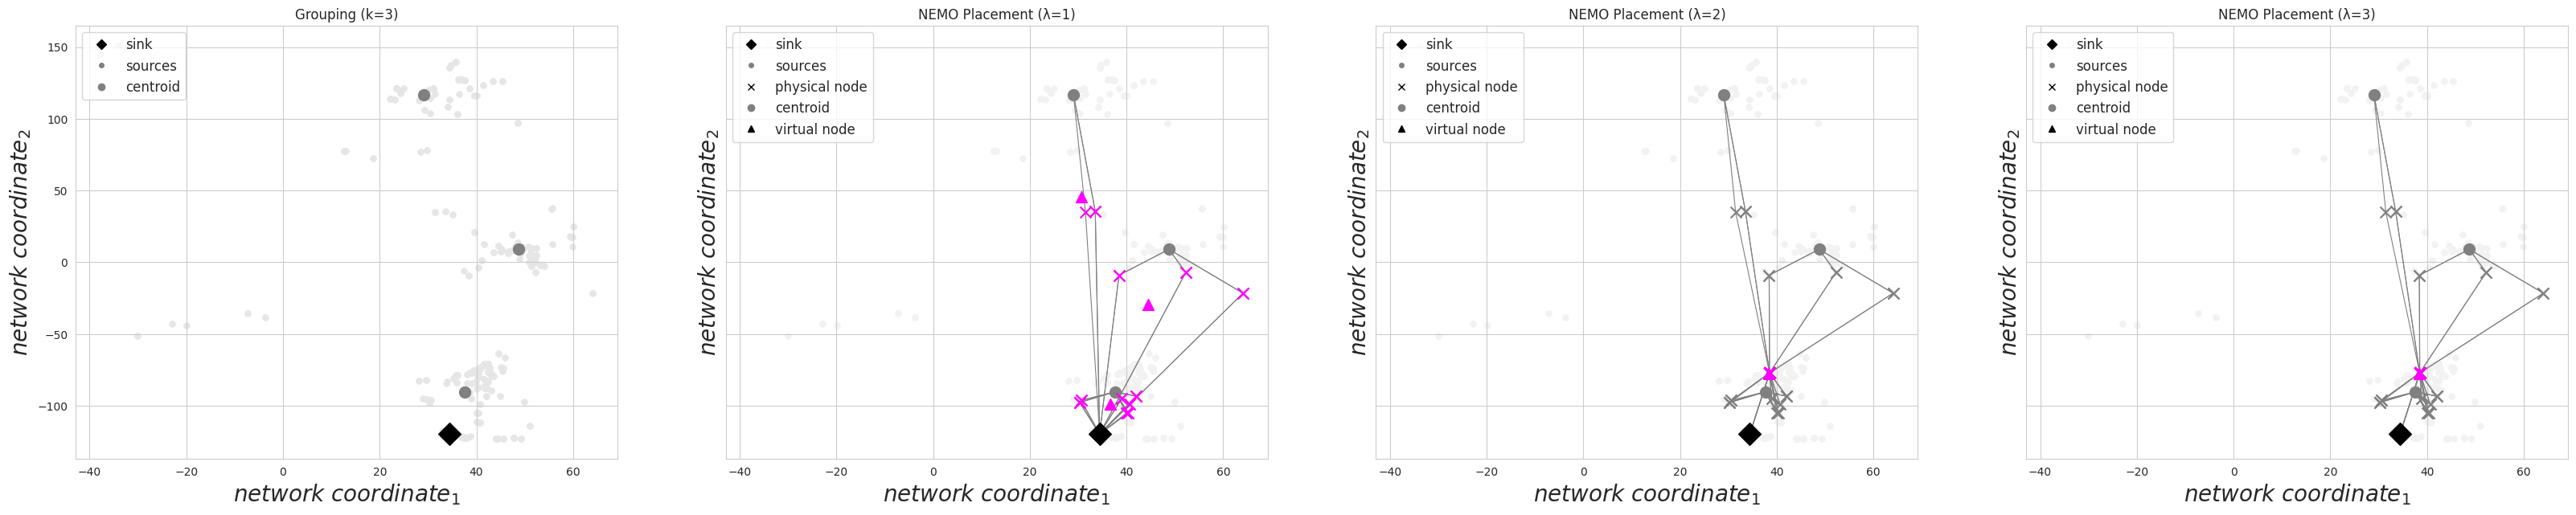

In [40]:
levels = [1, 2, 3]
fig, axs = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.1
weight_col_plot = "weight_2"
slot_col_plot = "capacity_10"
single_color = "grey"

util.plot_topology(axs[0], prim_df, None, title='Grouping (k=' + str(opt_k) + ")", plot_voronoi=True, plot_centroid=True, leg_size=leg_size,
                   symbol_size=symbol_size, scale_fac=scale_fac, axis_label_size=axis_label_size,
                   point_color=single_color, centroid_color=single_color)

for i, level in enumerate(levels):
    df_dict_i, opt_dict_i, limits_dict_i = evaluate_nemo(prim_df, [slot_col_plot], weight_col_plot,
                                                         merge_factor=param_dict[weight_col_plot]["merge_factor"],
                                                         step_size=param_dict[weight_col_plot]["step_size"],
                                                         max_levels=level, with_eval=False)
    
    util.plot_with_single_color(axs[i + 1], prim_df, df_dict_i[slot_col_plot], single_color,
                                opt_dict=opt_dict_i[slot_col_plot], leg_size=leg_size, symbol_size=symbol_size,
                                scale_fac=scale_fac, axis_label_size=axis_label_size, lval=lval, plot_centroids=True,
                                plot_lines=True, highlight_color="magenta")
    axs[i+1].set_title(f"NEMO Placement (λ={str(level)})")

plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.show()

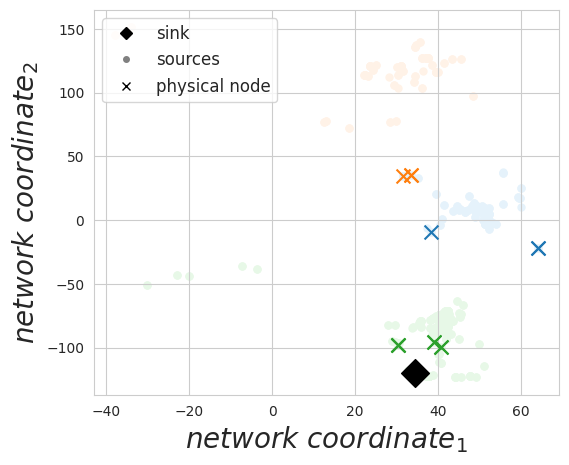

In [41]:
ax = plt.figure(figsize=(6, 5)).gca()

#uncomment this to plot nemo grouping
#ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
#ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
#ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)
#ax2.set_title('Grouping (k=' + str(opt_k) + ")")
#fig.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

#uncomment this for nemo placement
util.plot(ax, prim_df, df_dict_1[slot_col], colors, lval=lval, plot_centroids=False, plot_lines=False)

#uncomment this for nemo redistribution
#util.plot(fig, new_paths_flat[slot_col], agg_dict_flat[slot_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)


ax.set_xlabel('$network$ $coordinate_1$')
ax.set_ylabel('$network$ $coordinate_2$')

plt.savefig("plots/planetlab/nemo_placement.svg", bbox_inches="tight")

Distribution of workload:  1.919 %


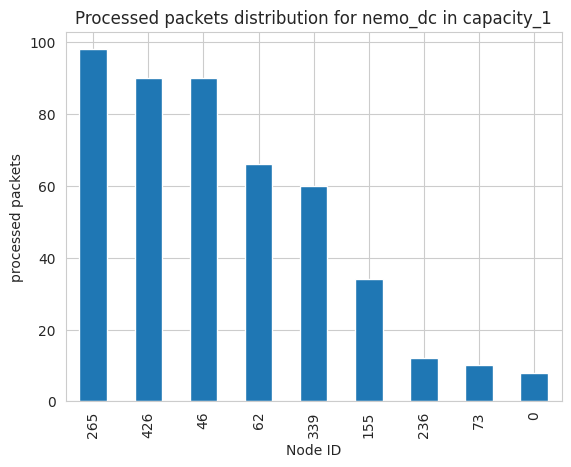

In [42]:
eval_col = list(eval_matrix[eval_name])[-1]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 3: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [43]:
# the adjacency matrix for the plane
df = prim_df.copy()
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:17999.0, valueBest:17999.0
i:10, t(i):3.49, valueNow:11659.0, valueBest:11656.0
i:20, t(i):1.22, valueNow:9890.0, valueBest:9889.0
i:30, t(i):0.42, valueNow:9101.0, valueBest:9101.0
i:40, t(i):0.15, valueNow:8815.0, valueBest:8815.0
i:50, t(i):0.05, valueNow:8545.0, valueBest:8545.0
i:60, t(i):0.02, valueNow:8293.0, valueBest:8293.0


In [44]:
print(route)

[335 275 310 305 392 395 430 345 446 341 185 468 343 442  35 354  77 172
 391 113 404 398  49  47 327 105 329 427 207 339 357 221 244 372 406 215
 197 173 174  33  84 196 157 397 373 463 464 434 403 456  76 132  44 116
 380 315 123 396 458 106 202 421 422 418  52  51 361 161 184 228   1 262
 200 324 261 101 362 363 260  53 256 223  97 168  68  69   4 412 240 447
 258 317  37  38 386  18  15  67  70  31 415  93 230 365 379 232  75 182
 358 282 139 249 137 450 314 286 288 387 411 160 265 371 348 462 453 452
 417 162  43 129 130  14  13 257 199   6 128 108 439 133 440 243  12  11
 293 461  16  17 369 429 408 250  73 146 247 203  98  28  87 145 209 152
 159 136 127   5 459 206 460 383 431 222 381 325  96 382  66 198 191 229
 355  55  81  80  54 346 347  74 323 140  39 118 109  63 425  25  72 219
 227  22  19  62  46 312 148 218 217 143  95 320 135  79 321 121 241 138
 349 336 295 237 390 107 378  71  10 213 166 165 114  32  58  50  64 103
 104 410 326 419 233 433 189 190 255 239  45  94  2

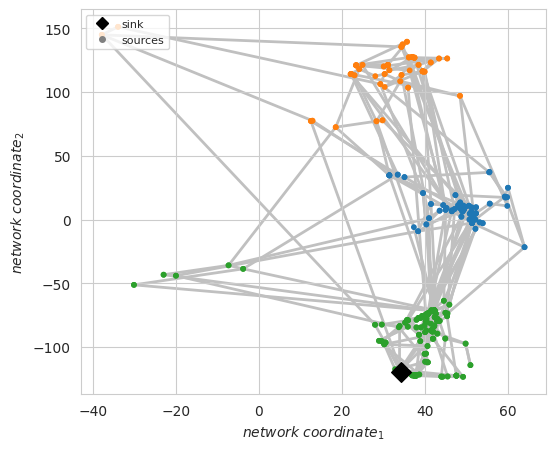

In [45]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/planetlab/chain_50n.svg", bbox_inches="tight")
plt.show()

In [46]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  349  in route.


In [47]:
print(df_stats["received_packets"])

0      2.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
464    1.0
465    1.0
466    1.0
467    1.0
468    1.0
Name: received_packets, Length: 469, dtype: float64


count     469.000000
mean     2268.167036
std      1565.374484
min         0.000000
25%       935.495690
50%      2187.065473
75%      3399.258421
max      5707.746635
Name: latency_distribution, dtype: float64


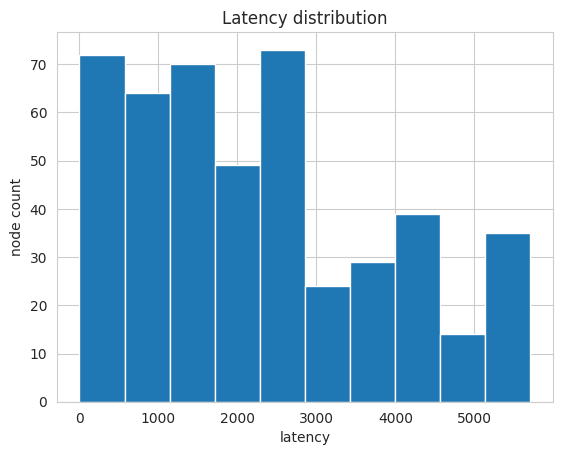

In [48]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count    469.000000
mean       0.997868
std        0.080036
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: received_packets, dtype: float64


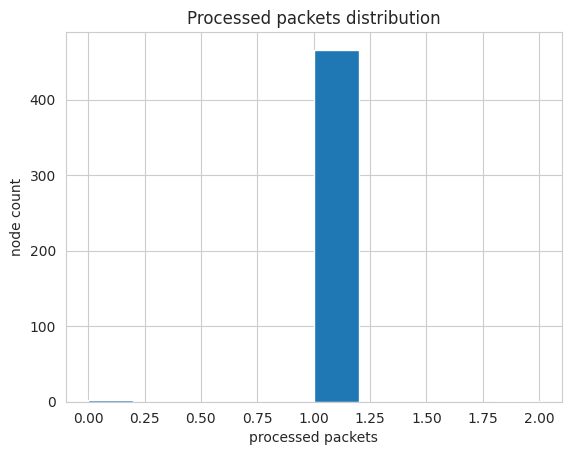

In [49]:
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [50]:
np.where(received_packets_hist > 1)

(array([0]),)

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [51]:
df = prim_df.copy()
mst = prim_mst(coords)

In [52]:
print(mst)

[-1, 195, 1, 95, 108, 56, 5, 258, 28, 8, 212, 90, 11, 343, 13, 10, 369, 16, 330, 18, 7, 219, 21, 21, 260, 24, 24, 0, 79, 28, 28, 208, 31, 441, 24, 34, 34, 433, 37, 3, 198, 40, 40, 465, 43, 43, 108, 360, 47, 47, 415, 399, 51, 33, 80, 54, 229, 56, 50, 50, 43, 60, 46, 46, 191, 382, 65, 27, 4, 4, 0, 100, 71, 425, 73, 1, 75, 75, 54, 320, 93, 80, 79, 65, 13, 84, 28, 28, 90, 88, 301, 90, 33, 100, 93, 140, 441, 96, 28, 95, 21, 100, 83, 334, 103, 210, 105, 84, 73, 108, 286, 107, 110, 403, 95, 95, 113, 10, 117, 0, 119, 136, 121, 137, 123, 123, 123, 4, 127, 43, 43, 43, 43, 438, 133, 121, 143, 276, 339, 137, 119, 140, 140, 208, 143, 143, 143, 143, 143, 143, 143, 143, 143, 143, 138, 138, 390, 156, 156, 95, 156, 156, 356, 90, 90, 119, 165, 165, 40, 168, 174, 170, 184, 172, 107, 174, 423, 176, 241, 178, 28, 180, 465, 182, 43, 184, 16, 186, 162, 457, 189, 5, 191, 92, 427, 231, 195, 194, 364, 198, 459, 239, 201, 136, 95, 156, 200, 138, 95, 208, 201, 210, 27, 212, 396, 214, 143, 143, 143, 226, 270, 220,

In [53]:
routes = createRoutes(mst)
print(routes[3])

[95, 140, 119, 0]


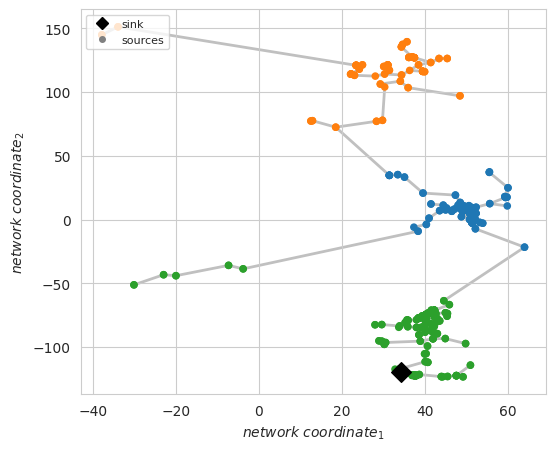

In [54]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=colors[labels], ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/planetlab/mst.svg", bbox_inches="tight")
plt.show()

In [55]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

count    469.000000
mean     120.882513
std      103.475711
min        0.000000
25%       42.566292
50%       56.887239
75%      176.777403
max      373.533440
Name: latency_distribution, dtype: float64


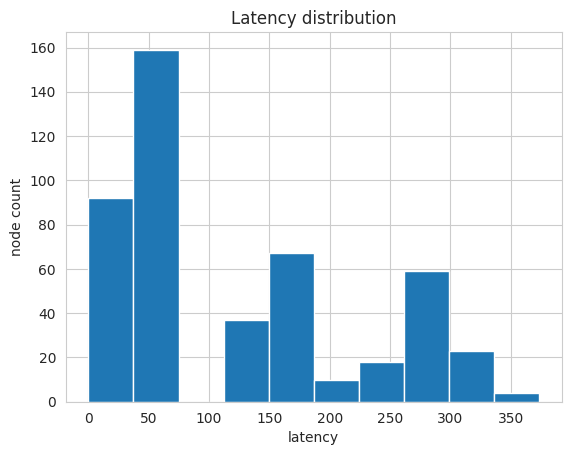

In [56]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

Distribution of workload:  40.7249 %


Text(0.5, 1.0, 'Processed packets distribution')

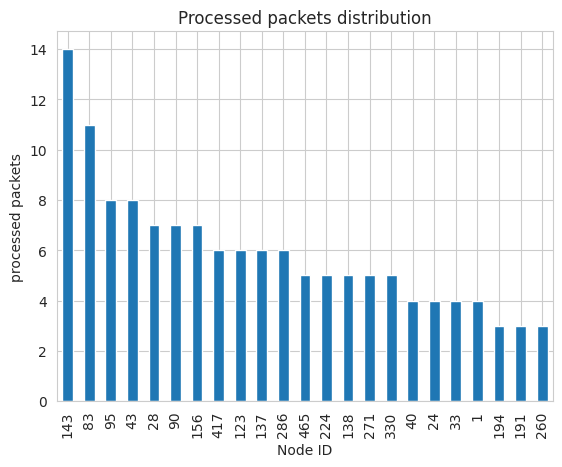

In [57]:
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")

df_packets = df_packets.head(int(round(device_number * 0.05)))
df_packets.plot.bar()

plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution")

In [58]:
eval_matrix["mst"] = df_stats.copy()

## Evaluation

In [59]:
eval_matrix.keys()

dict_keys(['dt', 'leach', 'nemo_dc_weight_2', 'nemo_dc_weight', 'nemo_dc', 'chain', 'mst'])

In [60]:
eval_matrix["nemo_dc"].keys()

dict_keys(['capacity_100', 'capacity_90', 'capacity_80', 'capacity_70', 'capacity_60', 'capacity_50', 'capacity_40', 'capacity_30', 'capacity_20', 'capacity_10', 'capacity_5', 'capacity_1'])

In [61]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

#### Latency

In [62]:
heterogen_appr

['nemo_dc', 'nemo_dc_weight_2', 'nemo_dc_weight']

In [63]:
ecolors, elight_colors, epalette = util.get_color_list(20)

eval_colors = {
    "dt": ecolors[0],
    "leach": ecolors[1],
    "mst": ecolors[2],
    "chain": ecolors[3],
    "nemo": ecolors[4],
    "nemo_base": ecolors[4],
    "nemo_dc_base": ecolors[4],
    "NEMO_base": ecolors[4],
    "nemo_rc": ecolors[5],
    "nemo_rc_base": ecolors[5],
    "nemo (rdm groups)_base": ecolors[5],
    "nemo_dc": ecolors[6],
    "NEMO+redistribution": ecolors[6],
    "nemo_pen": ecolors[7],
    "nemo_pen_base": ecolors[8],
    "nemo_dc_weight_2": ecolors[9],
    "nemo_dc_weight": ecolors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
    "capacity_100": "m=" + first_med_label,
    "capacity_1": "m=" + last_med_label
}


In [64]:
eval_matrix["dt"]["latency_distribution"].mean()

96.95220066287571

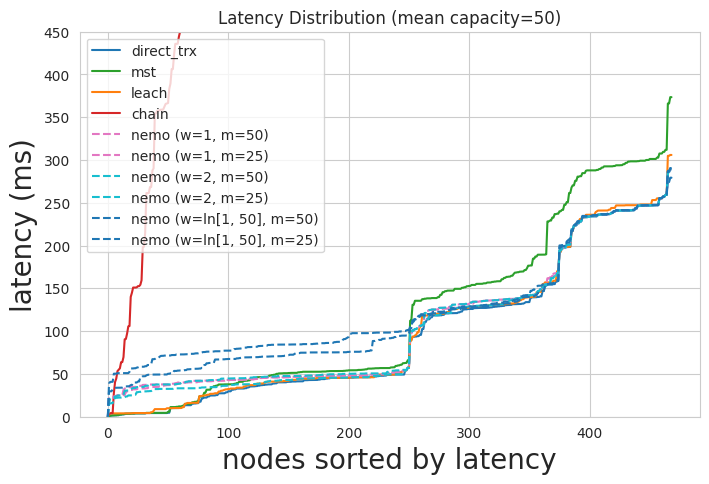

Means:  {'dt': 96.95, 'mst': 120.88, 'leach': 99.5, 'chain': 2268.17, 'nemo (w=1, m=50)': 105.67, 'nemo (w=1, m=25)': 106.33, 'nemo (w=2, m=50)': 102.91, 'nemo (w=2, m=25)': 106.59, 'nemo (w=ln[1, 50], m=50)': 117.75, 'nemo (w=ln[1, 50], m=25)': 125.57}
Quantiles:  {'dt': 240.08, 'mst': 293.21, 'leach': 244.64, 'chain': 4607.65, 'nemo (w=1, m=50)': 240.12, 'nemo (w=1, m=25)': 240.12, 'nemo (w=2, m=50)': 240.09, 'nemo (w=2, m=25)': 240.09, 'nemo (w=ln[1, 50], m=50)': 240.57, 'nemo (w=ln[1, 50], m=25)': 240.14}


In [65]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for approach in heterogen_appr:
    cl = approach
    emat = eval_matrix[approach]

    for capacity, df in emat.items():
        if capacity not in ["capacity_100", "capacity_1"]:
            continue
        l = renaming_dict[approach] + " " + renaming_dict[capacity] + ")"
            
        sv = df["latency_distribution"].sort_values()
        quant_dict[l] = round(sv.quantile(0.9), 2)
        mean_dict[l] = round(sv.mean(), 2)
        sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl], linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
plt.ylim([0, 450])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

plt.savefig("plots/planetlab/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

#### Heterogeneity

In [66]:
aggregation_fams

['dt', 'leach', 'mst', 'chain']

In [67]:
eval_matrix_load = eval_matrix.copy()
eval_matrix_load.pop("nemo_dc_weight_2")
eval_matrix_load.pop("nemo_dc_weight")
eval_matrix_load.keys()

dict_keys(['dt', 'leach', 'nemo_dc', 'chain', 'mst'])

In [68]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

In [69]:
load_dict

{'dt': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'leach': [0.05, 0.05, 0.1, 0.1, 0.15, 0.15, 0.25, 0.4, 0.55, 1.75, 2.6, 10.4],
 'chain': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43],
 'mst': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17]}

In [70]:
load_dict = {}
nn_dict = {}

for k, df in eval_matrix_load.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in slot_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in slot_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix_load.items():
    if k in heterogen_appr:
        slot_list = []
        nn_list = []
        for colname in slot_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            slot_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

#for k, mat in eval_matrix.items():
#    if k in heterogen_appr:
#        slot_list = []
#        nn_list = []
#        for colname in slot_columns:
#            df = mat["base"]
#            df["av_capacity"] = prim_df[colname] - df["received_packets"]
#            tmp_df_sl = df[df["av_capacity"] < 0]
#            tmp_df_nn = df[df["av_capacity"] >= 0]
#            slot_list.append(tmp_df_sl["av_capacity"].count())
#            nn_list.append(tmp_df_nn["av_capacity"].count())
#        load_dict[k + "_base"] = slot_list
#        nn_dict[k + "_base"] = nn_list

In [71]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

In [72]:
agg_arr1 = []
for fam in eval_matrix_load.keys():
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])

#agg_arr2 = []
#for fam in eval_matrix_load.keys():
#    agg_arr2.append(load_dict[fam + "_base"])
#mr = np.mean(np.array(agg_arr2), axis=0)
#load_dict["NEMO_base"] = mr
#print(mr)

Fam:  dt
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fam:  leach
[0.05, 0.05, 0.1, 0.1, 0.15, 0.15, 0.25, 0.4, 0.55, 1.75, 2.6, 10.4]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  chain
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43]
Fam:  mst
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17]


dt [51. 51. 51. 50. 49. 49. 47. 44. 42. 36. 31. 27.]
dt [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
leach [51. 51. 51. 50. 49. 49. 47. 44. 42. 36. 31. 27.]
leach [0.05, 0.05, 0.1, 0.1, 0.15, 0.15, 0.25, 0.4, 0.55, 1.75, 2.6, 10.4]
chain [51. 51. 51. 50. 49. 49. 47. 44. 42. 36. 31. 27.]
chain [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 43]
mst [51. 51. 51. 50. 49. 49. 47. 44. 42. 36. 31. 27.]
mst [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17]
nemo_dc [51. 51. 51. 50. 49. 49. 47. 44. 42. 36. 31. 27.]
nemo_dc [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


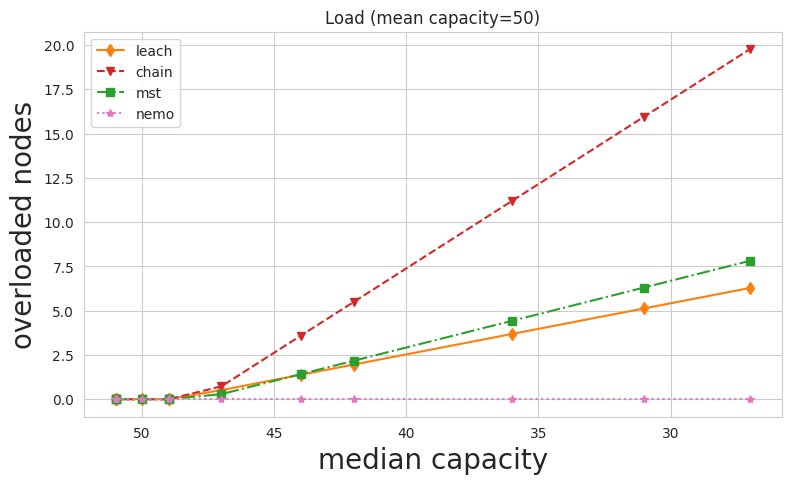

In [73]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    print(fam, medians)
    print(fam, vals)
    m, b = np.polyfit(medians, vals, 1)
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "nemo_dc":
        fam = "nemo"
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)

plt.savefig("plots/planetlab/eval_load_abs.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()


In [74]:
load_dict.keys()

dict_keys(['dt', 'leach', 'chain', 'mst', 'nemo_dc'])

leach - d #ff7f0e : [0.10869565217391304, 0.10869565217391304, 0.21739130434782608, 0.21739130434782608, 0.32608695652173914, 0.32608695652173914, 0.5434782608695652, 0.8695652173913043, 1.1956521739130435, 3.804347826086957, 5.6521739130434785, 22.608695652173914]
chain -- v #d62728 : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.207708779443255]
mst -. s #2ca02c : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.264957264957266]
nemo : * #e377c2 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


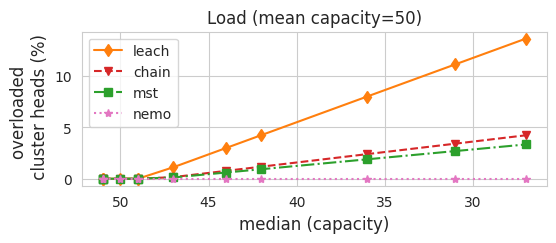

In [75]:
fig, ax = plt.subplots(figsize=(6, 2))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in load_dict.keys():
    vals = load_dict[fam]
    evcol = fam
    if fam == "dt":
        fam = "direct_trx"
        vals = [100 for x in vals]
        continue
    if fam == "leach":
        vals = [x / num_leach_clusters * 100 for x in vals]
    if fam == "mst":
        agg_points = (device_number - 1) / 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "chain":
        agg_points = device_number - 2
        vals = [x / agg_points * 100 for x in vals]
    if fam == "nemo_dc":
        fam = "nemo"
    m, b = np.polyfit(medians, vals, 1)
    print(fam, styles[i], markers[i], eval_colors[evcol], ":", vals)
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median (capacity)")
ax.set_ylabel("overloaded \n cluster heads (%)")
#ax.set_yscale('log')
ax.legend()

ax.yaxis.label.set_size(12)
ax.xaxis.label.set_size(12)

plt.savefig("plots/planetlab/eval_load_perc.svg")
ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()

In [76]:
quant_dict

{'dt': 240.08,
 'mst': 293.21,
 'leach': 244.64,
 'chain': 4607.65,
 'nemo (w=1, m=50)': 240.12,
 'nemo (w=1, m=25)': 240.12,
 'nemo (w=2, m=50)': 240.09,
 'nemo (w=2, m=25)': 240.09,
 'nemo (w=ln[1, 50], m=50)': 240.57,
 'nemo (w=ln[1, 50], m=25)': 240.14}

In [77]:
mean_dict

{'dt': 96.95,
 'mst': 120.88,
 'leach': 99.5,
 'chain': 2268.17,
 'nemo (w=1, m=50)': 105.67,
 'nemo (w=1, m=25)': 106.33,
 'nemo (w=2, m=50)': 102.91,
 'nemo (w=2, m=25)': 106.59,
 'nemo (w=ln[1, 50], m=50)': 117.75,
 'nemo (w=ln[1, 50], m=25)': 125.57}